In [313]:
import sys
sys.path.append("../../")

In [314]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [315]:
data=pl.read_csv("featureEngineered.csv")
data

curbweight,cylindernumber,price,carvolume,enginepower,averagempg
i64,i64,f64,f64,f64,f64
2548,0,13495.0,528019.904,4.6132e6,23.7
2548,0,16500.0,528019.904,4.6132e6,23.7
2823,1,16500.0,587592.64,4.4555e6,22.15
2337,0,13950.0,634816.956,3.8413e6,26.7
2824,1,17450.0,636734.832,4.9171e6,19.8
…,…,…,…,…,…
2952,0,16845.0,721961.76,5.9200e6,25.25
3049,0,19045.0,720913.92,6.2262e6,21.7
3012,1,21485.0,721961.76,7.2457e6,20.25


In [316]:
df=data[['curbweight','cylindernumber','carvolume','enginepower','averagempg','price']]
data=df

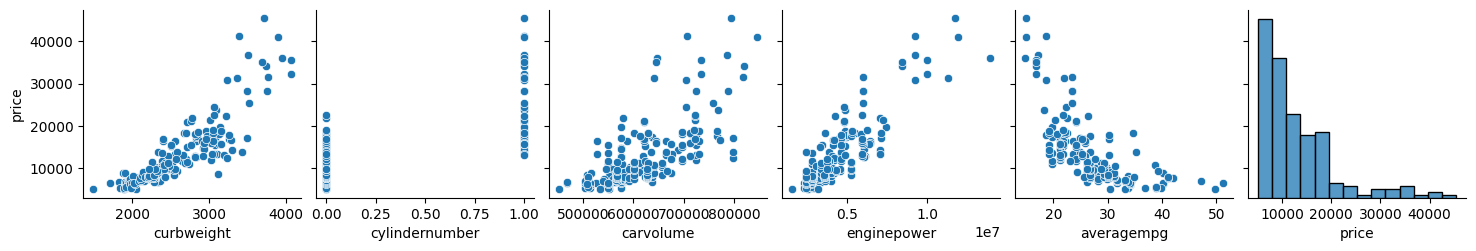

In [317]:
sns.pairplot(data.to_pandas(),y_vars="price")

<AxesSubplot: >

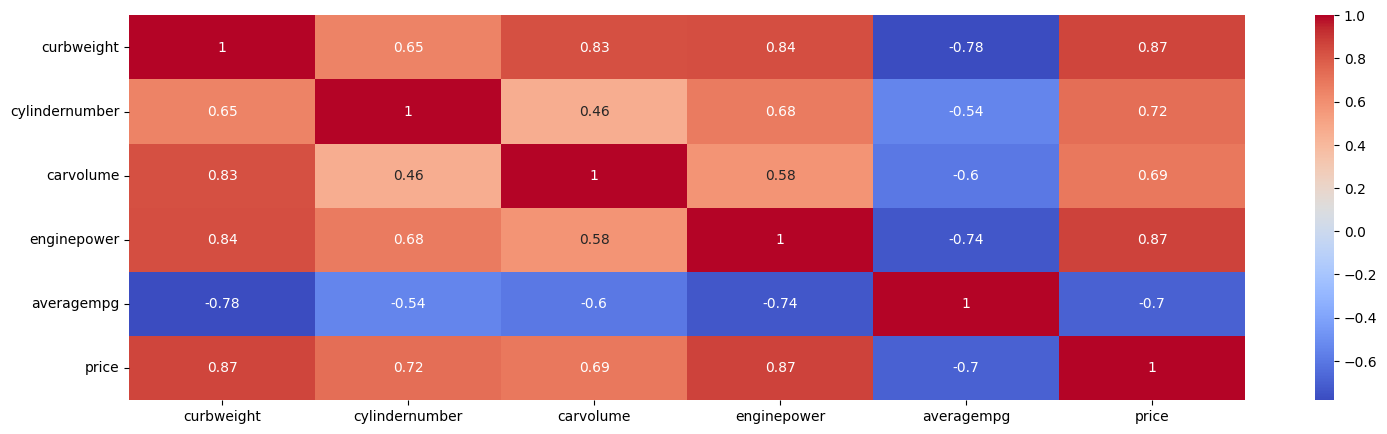

In [318]:
plt.figure(figsize=(18,5))
sns.heatmap(data.to_pandas().corr(),annot=True,cmap='coolwarm')

No features are  collinear more than .85 

# Model trained in feature engineering

Test Scores: [0.83409983 0.85156948 0.82409121]
Training Scores: [0.85421469 0.85075627 0.86504919]
Mean Test Score: 0.8365868409284816
Standard Deviation of Test Scores: 0.011354961335585239
Mean absolute Error: 2626.958096532359
R-squared: 0.8178793842904633


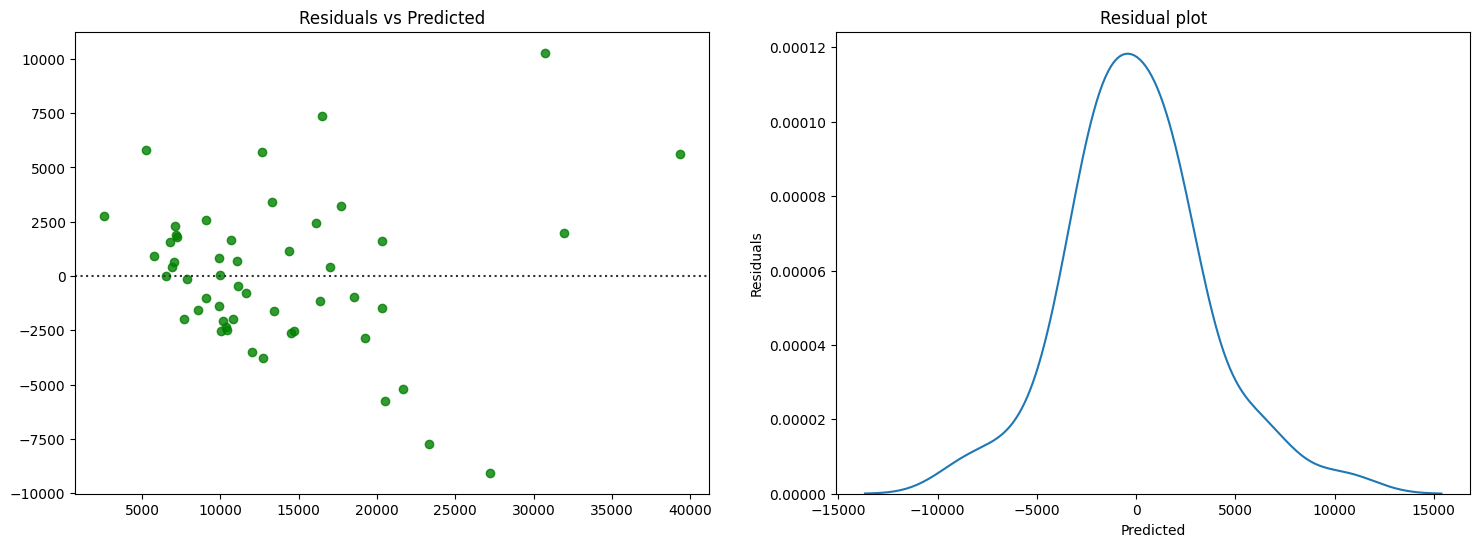

In [319]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=kf)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Analysing the residuals

Test Scores: [0.79871547 0.82846425 0.60271546]
Training Scores: [0.83985923 0.8430592  0.86104598]
Mean Test Score: 0.743298392181348
Standard Deviation of Test Scores: 0.10014628912874343
Mean absolute Error: 2434.1190829104817
R-squared: 0.7984346340123956


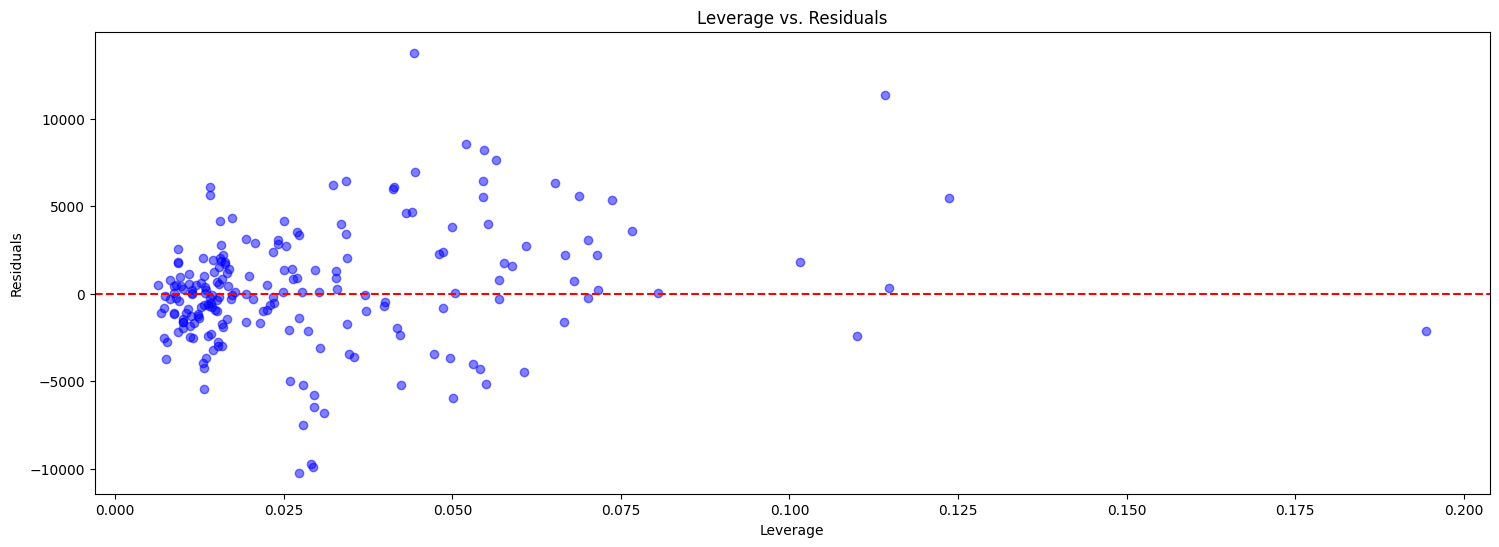

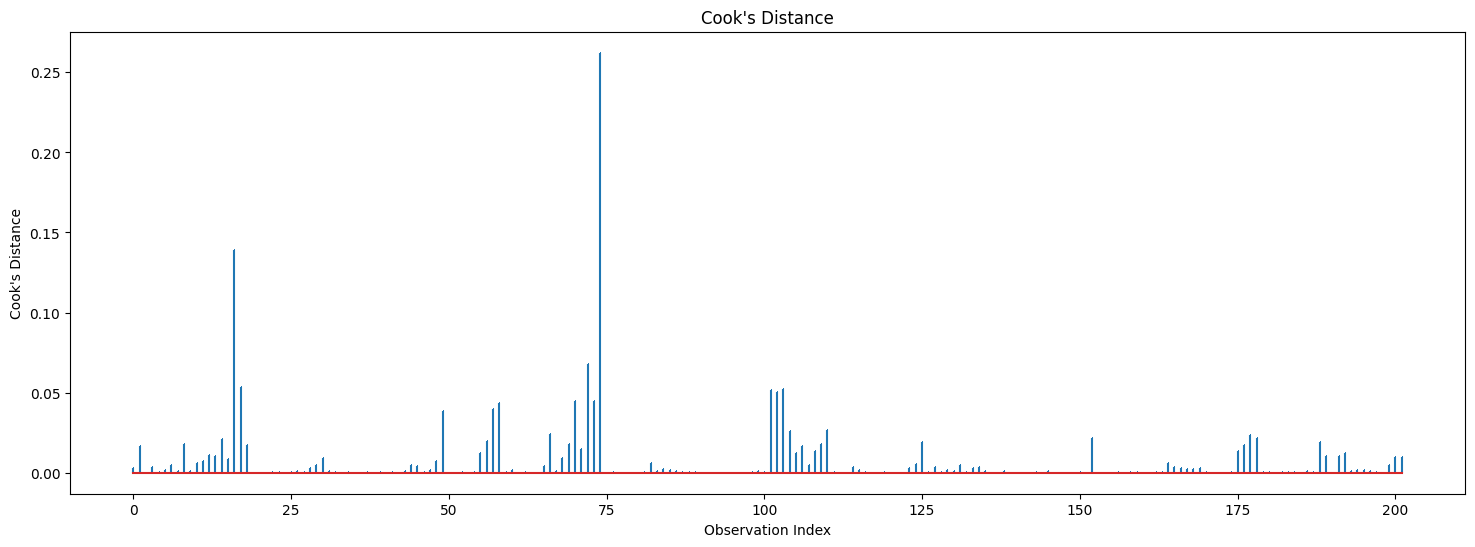

Influential points: [ 14  16  17  49  57  58  66  70  72  73  74 101 102 103 104 110 152 177
 178]


In [320]:
import statsmodels.api as sm
X=data.drop('price').to_pandas()
y=data['price'].to_pandas()

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=0)

# Initialize and fit the Linear Regression model
lr = LinearRegression()
from sklearn.model_selection import KFold
kf=KFold(n_splits=3)
# Cross-validation
cv_results = cross_validate(lr, X, y, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

# Predictions
predictions = cross_val_predict(lr, X, y, cv=kf)
residuals = y - predictions
mse = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

# Compute leverage, Cook's distance using statsmodels
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
influence = model.get_influence()

# Leverage values
leverage = influence.hat_matrix_diag
# Cook's distance
cooks_d = influence.cooks_distance[0]

# Convert to DataFrame for better visualization
influence_df = pd.DataFrame({
    'Leverage': leverage,
    'Cooks Distance': cooks_d,
    'Residuals': residuals
})

# Plotting leverage vs. residuals
plt.figure(figsize=(18,6))
plt.scatter(leverage, residuals, alpha=0.5, color='blue')
plt.axhline(y=0,color='red', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Leverage vs. Residuals')
plt.show()

# Plotting Cook's distance
plt.figure(figsize=(18,6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance')
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > 4 / len(y))[0]
print(f'Influential points: {influential_points}')

In [321]:
data[influential_points]

curbweight,cylindernumber,carvolume,enginepower,averagempg,price
i64,i64,f64,f64,f64,f64
3055,1,704276.37,4.8051e6,22.25,24565.0
3380,1,706639.374,9.2336e6,18.7,41315.0
3505,1,786358.99,9.2336e6,17.25,36880.0
3950,1,646926.156,1.3954e7,14.8,36000.0
2385,0,550723.68,2.8032e6,19.7,13645.0
…,…,…,…,…,…
3071,1,576049.341,7.1156e6,21.7,17199.0
3430,0,798599.412,4.6159e6,25.0,13860.0
3110,0,637861.572,2.4141e6,29.25,8778.0


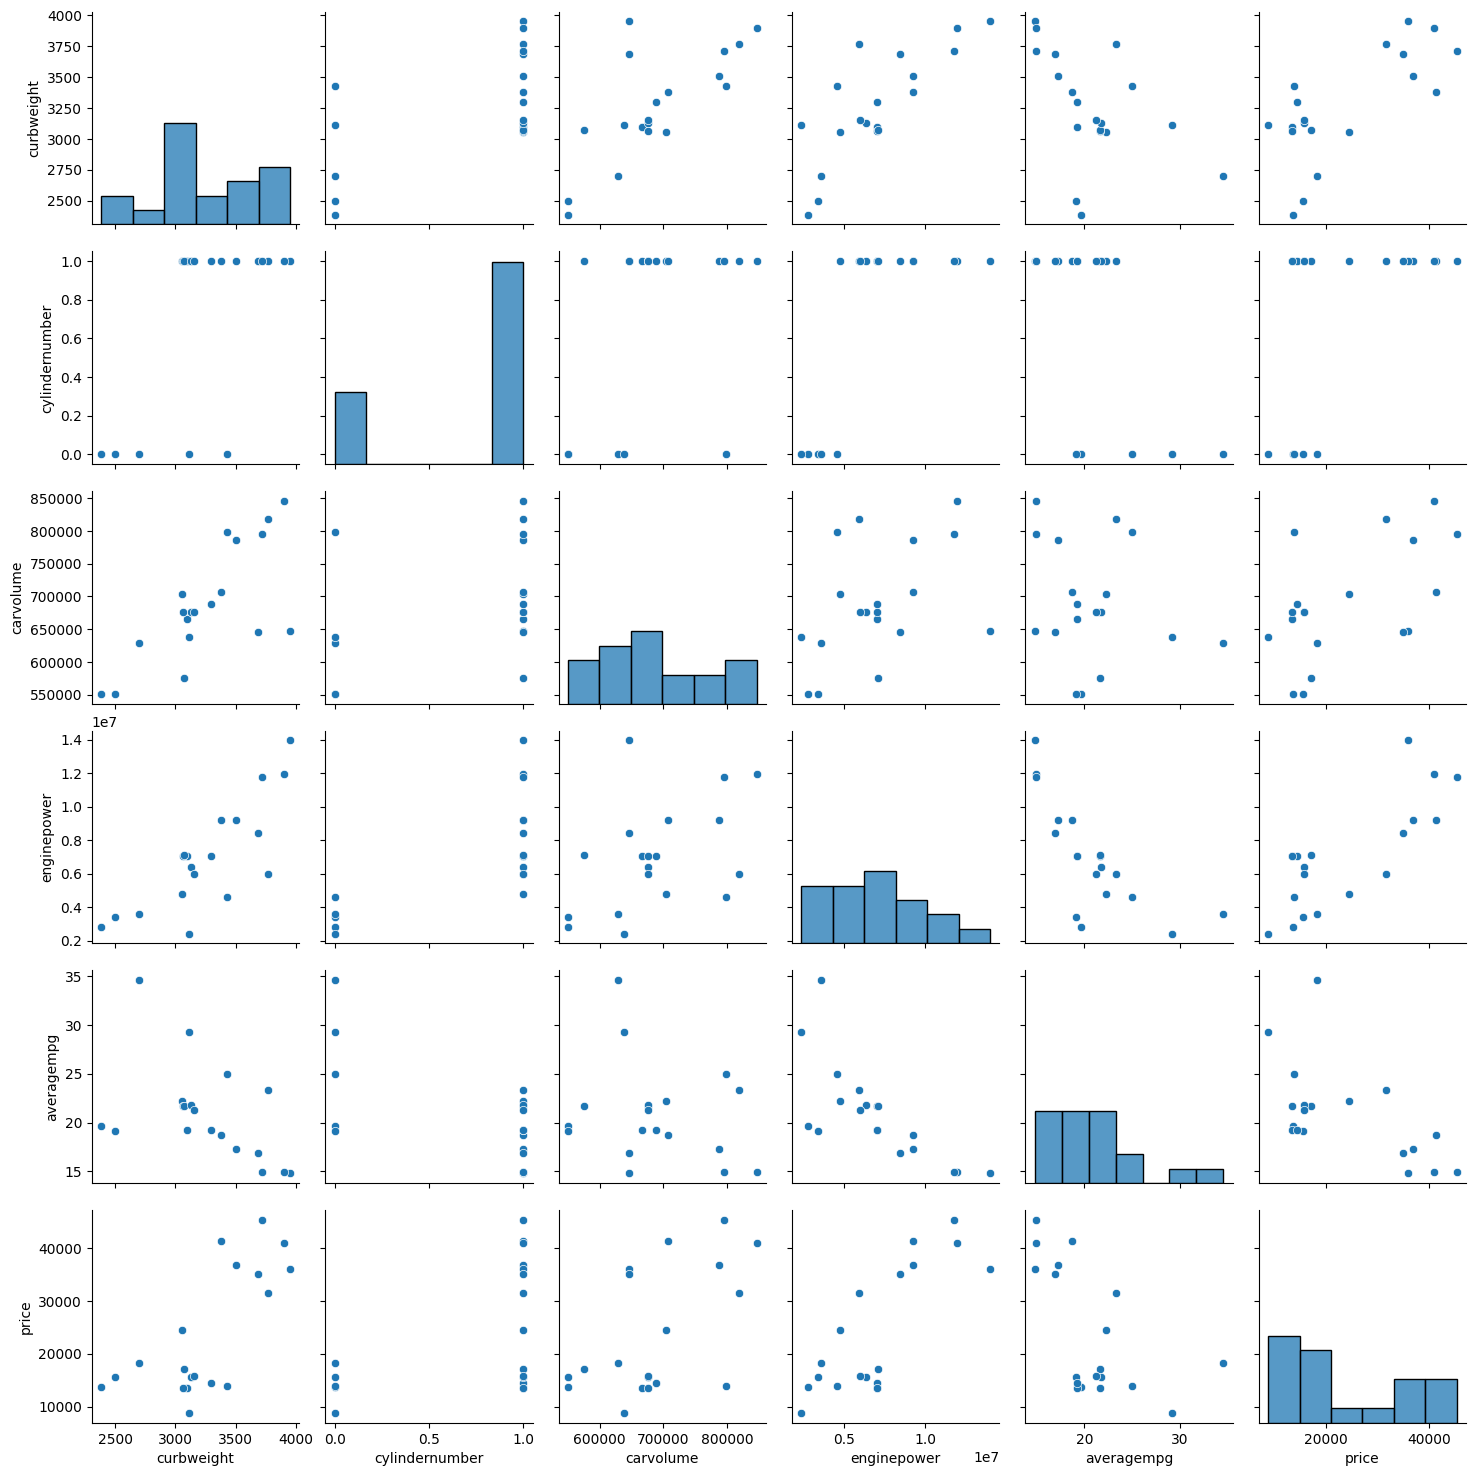

In [322]:
sns.pairplot(data[influential_points].to_pandas())

# Removing inflential points

In [302]:
data=data.with_row_index().filter(~pl.col("index").is_in(influential_points))

Test Scores: [0.76828234 0.84096199 0.72579029]
Training Scores: [0.84856618 0.81248528 0.85263783]
Mean Test Score: 0.778344872076414
Standard Deviation of Test Scores: 0.04755397661226757
Mean absolute Error: 1891.0329899296114
R-squared: 0.9023315619761927


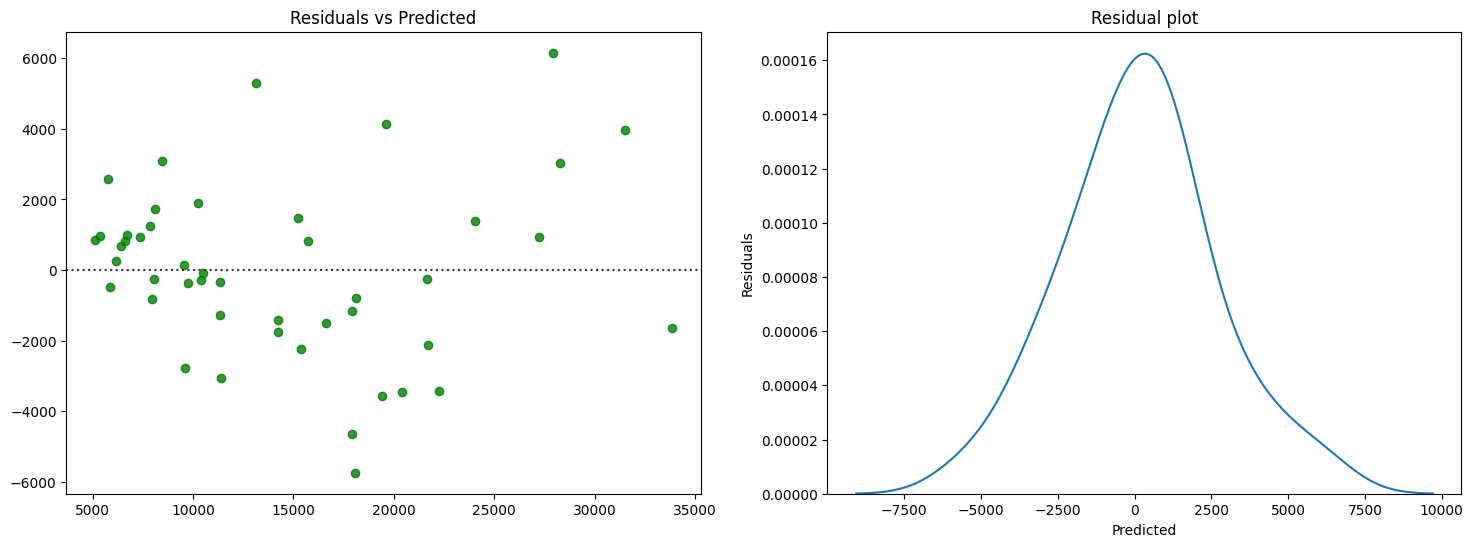

In [311]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=5)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

In [312]:
n = X_test.shape[0]
p = X_train.shape[1]

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')

R-squared: 0.9023315619761927
Adjusted R-squared: 0.8873056484340685


### R2 score increased from 81 to 90 and mean_absolute_error descreased from 2626 to 1891

# Residuals are more normalized. and residual range decreased from -10k to 10K to -6k to 6k

But the mean of test score on cross validation decreased from 83 to 78